#  Logistic Regression and Classification Error Metrics

## <span style="color:blue">Alunos</span>

<ul>
    <li>Diego Santos Gonçalves - 20183012537</li>
    <li>Mariana Bulgarelli Alves dos Santos - 20183000330</li>
</ul>

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website: above or at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones 

In [42]:
from __future__ import print_function
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import os
import pickle
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['../../']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [9]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [10]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [11]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [12]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [13]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [14]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

9684     3
2945     0
3532     3
10051    4
5903     1
Name: Activity, dtype: int32

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [16]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

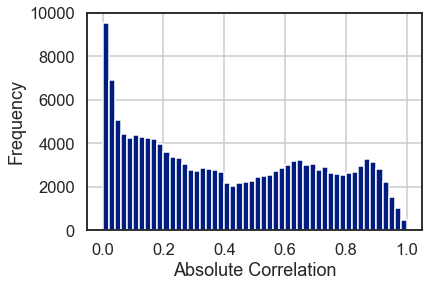

In [18]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [19]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']


In [21]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [22]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [16]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(max_iter=500, penalty='none').fit(X_train, y_train)
lr.coef_

array([[ -72.59754795,   12.32427208,   16.21886472, ...,  627.00260654,
        -239.55648089,  -56.83034869],
       [-237.74670101,  -93.2319069 ,   26.78555557, ...,  -68.77298671,
        -130.18248629,  -86.8186573 ],
       [ 108.42892719,   72.30661716,   78.42765402, ..., -265.05848213,
         215.73397989,   18.97337224],
       [   5.11515344,  -15.86361579,    4.44866939, ..., -113.70469674,
           4.95871362,   59.43114703],
       [ 139.75854785,   32.09034603,    1.54859909, ..., -230.3935513 ,
         -18.95909446,   -8.72447285],
       [  57.04162049,   -7.62571258, -127.42934278, ...,   50.92711034,
         168.00536813,   73.96895957]])

Treinou-se o modelo utilizando o conjunto de dados de treino. Como parâmetros passados à função de regressão logística temos o número máximo de iterações de 500 e o tipo de penalidade (regularização) que foi definido como 'none'. Em seguida, obteve-se os valores dos coeficientes da função de custo.

In [17]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [28]:
lr_l1.coef_

array([[ 0.        ,  0.        ,  0.        , ...,  3.55620485,
        -0.6976506 ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -8.00971699,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.14547729,  0.        ,  0.        , ..., -0.44087012,
        -0.2105932 ,  0.        ],
       [ 3.79142465,  0.        ,  0.        , ..., -0.69439424,
         0.        ,  0.        ],
       [-0.48598364,  0.        , -0.25246446, ...,  0.3021803 ,
         2.18878905,  1.92441364]])

In [ ]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations
# Comentamos o código pois este solver não existe para lasso regression.


In [ ]:
# Comentamos o código pois estes solvers não existem para lasso regression.
'''lr_l1_lbfgs = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='lbfgs').fit(X_train, y_train)'''
'''lr_l1_sag = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='sag').fit(X_train, y_train)'''
#lr_l1_newton = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='newton-cg').fit(X_train, y_train)

In [23]:
lr_l1_saga = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga').fit(X_train, y_train)

C:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\maria\A

In [24]:
lr_l1_saga.coef_

array([[-9.54132071e-02,  1.54591081e-02,  2.56794069e-02, ...,
         1.87824761e+00, -6.73167859e-01, -8.77210183e-02],
       [-3.64725681e-01, -1.57197949e-01, -4.38332354e-02, ...,
        -3.63178088e-01, -2.43439842e-01, -1.96940846e-01],
       [ 2.82017594e-01,  1.10329268e-01,  1.02811154e-01, ...,
        -5.89823507e-01,  1.19092795e+00,  3.11639680e-01],
       [-1.04889624e-02, -9.28657976e-03,  7.64166163e-04, ...,
        -7.66966387e-02, -3.98408027e-02,  4.38535035e-02],
       [ 3.10540403e-01,  5.04501526e-02, -2.22826991e-02, ...,
        -4.51422403e-01, -1.34855778e-01, -1.40329591e-01],
       [-4.18376981e-02, -2.03587991e-02, -6.06386485e-02, ...,
         4.97111662e-01,  3.54685054e-01,  1.25543613e-01]])

<span style="color:red">---------------------------------------------------------------------------------------------</span>
## <span style="color:red">RESPOSTA</span>

Nesta parte, são executadas as regressões logísticas considerando a lasso regression para diferentes solvers. No entanto, alguns solvers não estão disponíveis para l1: newton-cg, lbfgs e sag. Estes solvers fazem uso de derivada para cálculo.
A penalidade lasso diminui alguns coeficiente, podendo chegar a zero. A penalidade L1 não é derivável, o que seria problemático para métodos quasi-newton.
Observa-se que a utilização do solver saga resultou em um tempo maior de execução em relação à liblinear. Idealmente, o liblinear é uma melhor escolha para conjunto de dados pequenos, enquanto a saga atua bem para conjuntos de dados maiores.

<span style="color:red">---------------------------------------------------------------------------------------------</span>

In [25]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train, y_train)

In [27]:
lr_l2.coef_

array([[-5.65101556e-02,  3.59693620e-02, -2.84105511e-03, ...,
         5.60655766e+00, -3.12452277e+00, -3.14027671e-01],
       [-2.24334841e+00, -1.54836147e+00, -1.07255994e+00, ...,
        -3.51744317e+00, -1.65897986e+00, -1.24350561e-01],
       [ 2.00344077e+00,  1.39297827e+00,  1.58588317e+00, ...,
        -1.90475677e+00,  4.73572575e+00,  2.75429080e-01],
       [-8.03482048e-02, -4.33613530e-02, -1.03945673e-02, ...,
        -3.88614218e-01, -2.35990293e-01,  1.54575732e-01],
       [ 6.46884988e-01,  2.64744795e-01, -9.50717963e-02, ...,
        -8.98736865e-01, -5.87510360e-01, -4.47833961e-01],
       [-2.70118980e-01, -1.01969599e-01, -4.05015809e-01, ...,
         1.10299336e+00,  8.71277543e-01,  4.56207380e-01]])

In [29]:
import pickle
with open('arquivo_lr_l1.pickle', 'wb') as f:
    pickle.dump(lr_l1, f)
with open('arquivo_lr_l1_saga.pickle', 'wb') as f:
    pickle.dump(lr_l1_saga, f)
with open('arquivo_lr_l2.pickle', 'wb') as f:
    pickle.dump(lr_l2, f)

In [ ]:
with open('arquivo_lr.pickle', 'wb') as f:
    pickle.dump(lr, f)

<span style="color:red">---------------------------------------------------------------------------------------------</span>
## <span style="color:red">RESPOSTA</span>

Aqui é executada a regressão logística utilizando o l2 como penalidade. Por padrão, o solver de l2 é o lbfgs. 

<span style="color:red">---------------------------------------------------------------------------------------------</span>

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [30]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

#for lab,mod in zip(coeff_labels, coeff_models):
#    coeffs = mod.coef_
#    levels=[[lab], [0,1,2,3,4,5]]
#    labels=[[0,0,0,0,0,0], [0,1,2,3,4,5]]
#    coeff_label = pd.MultiIndex(levels,labels)
#    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)



lr                                                              \
              0           1           2           3           4           5   
284  -73.617778  -53.267537  -77.897683  -17.558910  125.237901   97.104007   
524  -51.236112  151.882288    9.327376  -56.694591  -71.987814   18.708854   
513   27.455021  216.843554   55.107958 -276.150074  -96.384255   73.127795   
41   260.316689  266.032694 -338.842392   -0.607562   45.378959 -232.278388   
91   -26.568811   60.777629  -68.052025  -75.448659  140.984316  -31.692451   
167  -36.022682  -67.257192   49.133609    0.248471   72.581482  -18.683688   
419    2.638530   29.343263   49.961747   -3.293586   -6.594133  -72.055821   
62   103.397631  152.642453  -69.793670 -462.106980   87.613408  188.247157   
14    36.791337  160.887003  -90.280475   43.106010  -77.412452  -73.091422   
344  -83.472378 -104.089594  -32.578204   47.778247   60.933309  111.428619   

           l1                                                          l2  \
            0         1         2         3         4         5         0   
284  0.000000  0.000000  0.000000 -0.493443  1.453034  0.414326 -0.124917   
524 -0.089924  0.409222 -0.325117  0.499388 -0.010890  0.642755 -0.027525   
513  0.000000  0.000000 -0.437023 -1.964464  0.000000  1.326421 -0.015051   
41   0.000000  6.109126 -6.109357  0.611318  0.023726 -3.343540  3.224072   
91   0.000000  0.000000  0.000000 -0.259897  1.321853 -0.149668 -0.095548   
167 -0.235354  0.000000  0.000000  0.000000  0.011030 -0.370378 -0.062594   
419 -0.051960  0.038589  0.329037  0.024998  0.053020  0.166353 -0.063494   
62   0.195082  1.856974  0.000000 -3.336098  0.939737  3.070655  1.254558   
14   0.000000  1.571740  0.000000 -0.219887 -0.866732  0.000000 -0.013966   
344  0.000000  0.000000  0.000000  0.000000  0.266603  0.000000 -0.114454   

                                                       
            1         2         3         4         5  
284  1.131049 -1.562803 -0.331750  0.607558  0.280864  
524  1.308179 -1.365808 -0.224660 -0.308708  0.618521  
513  2.439164 -1.624830 -1.287170 -0.317789  0.805677  
41   4.351251 -7.516958  0.316954  0.885904 -1.261223  
91   1.392106 -1.535489 -0.510438  1.064439 -0.315070  
167 -1.318358  1.249286  0.076953  0.239697 -0.184983  
419  0.033914  0.055622  0.200843  0.035200 -0.262085  
62   2.070205 -2.087473 -3.156646  0.471392  1.447963  
14   2.931528 -2.355694  0.011867 -0.551185 -0.022549  
344 -1.233090  0.716668  0.024929  0.152821  0.453127

Prepare six separate plots for each of the multi-class coefficients.

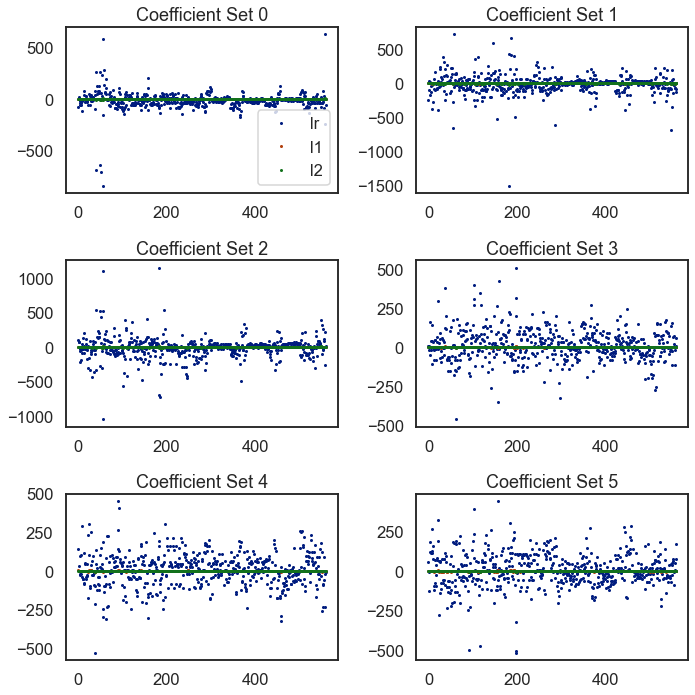

In [31]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()




<span style="color:red">---------------------------------------------------------------------------------------------</span>
## <span style="color:red">RESPOSTA</span>

Todos os coeficientes resultantes das regressoes logísticas sem regularização, com regularização l1 (solver=liblinear) e com regularização l2 (solver=lbfgs) são reunidos em um unico dataframe.
Conforme esperado, o modelo sem regularização apresentou valores de coeficiente maiores do que os modelos que utilizaram regularização. O modelo com regularização l1 apresentou alguns valores iguais a zero, o que também era esperado. Ambos os modelos com penalidade aplicada apresentaram valores menores que o modelo sem regularização. A regularização l2 atinge valores pequenos, porém nenhum deles é igual a zero.
Em seguida é plotado um conjunto de gráficos com os coeficientes encontrados para cada modelo. Nos gráficos, pode-se observar que os dados dos modelos regularizados com l1 e l2 se concentram próximos (l1 e l2) ou iguais a zero (l1). Os valores dos coeficientes são maiores. 


<span style="color:red">---------------------------------------------------------------------------------------------</span>

## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [32]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()



,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [33]:
y_prob.head()

,lr,l1,l2
0,1.0,0.998944,1.000000
1,1.0,0.999442,1.000000
2,1.0,0.995297,0.999996
3,1.0,0.999174,1.000000
4,1.0,0.999924,0.999999


In [34]:
y_pred

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0
...,...,...,...
3085,1,2,1
3086,3,3,3
3087,1,1,1
3088,1,1,1


<span style="color:red">---------------------------------------------------------------------------------------------</span>
## <span style="color:red">RESPOSTA</span>

Nesta etapa é realizada a predição dos valores para cada modelo e a probabilidade.

<span style="color:red">---------------------------------------------------------------------------------------------</span>

## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [35]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [36]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.983785,0.983835,0.983837
recall,0.983819,0.983819,0.983819
fscore,0.983790,0.983815,0.983823
accuracy,0.983819,0.983819,0.983819
auc,0.990181,0.990144,0.990158


<span style="color:red">---------------------------------------------------------------------------------------------</span>
## <span style="color:red">RESPOSTA</span>

Foram calculadas as métricas de avaliação dos modelos: acurácia, precisão, recall, f-score e a área sob a curva ROC. Os valores de todas as métricas foram quase iguais entre os métodos.


<span style="color:red">---------------------------------------------------------------------------------------------</span>

## Question 8

Display or plot the confusion matrix for each model.

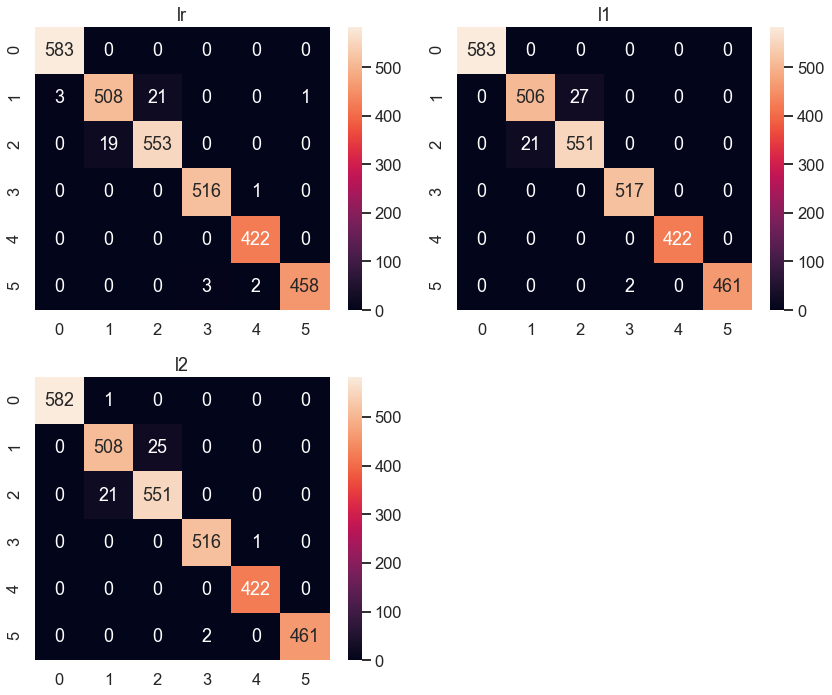

In [37]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


<span style="color:red">---------------------------------------------------------------------------------------------</span>
## <span style="color:red">RESPOSTA</span>

Aqui é plotada a matriz de confusão para cada um dos métodos. Observa-se que as classes 1 e 2 foram as que apresentaram mais erros de predição.

<span style="color:red">---------------------------------------------------------------------------------------------</span>

## Question 9
 Identify highly correlated columns and drop those columns before building models

In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold


X_data = data.iloc[:, :-1]


#threshold with .7
sel = VarianceThreshold(threshold=(.7 * (1 - .7)))
X_data = pd.DataFrame(sel.fit_transform(X_data))


feature_cols = X_data.columns[:]


# Dividindo os subjconjuntos de treino e teste, seguindo os mesmos
# Indices obtidos com Stratified Shuffle Split, agora com os dados
# Com menos features
 

X_train_new = X_data.loc[train_idx, :]

y_train_new = data.loc[train_idx, 'Activity']
 
X_test_new  = X_data.loc[test_idx, :]
y_test_new  = data.loc[test_idx, 'Activity']
 
print(X_train.shape)
print(X_train_new.shape)
 
print(X_test.shape)

(7209, 561)
(7209, 50)
(3090, 561)


 Repeat Model building with new training data after removing higly correlated columns

In [25]:
# Try standard, L1 and L2 Logistic regression
lr_new = LogisticRegression(max_iter=10000, penalty='none').fit(X_train_new, y_train_new)
with open('arquivo_lr_new.pickle', 'wb') as f:
    pickle.dump(lr_new, f)

In [33]:
lr_l1_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear', max_iter=10000).fit(X_train_new, y_train_new)
with open('arquivo_lr_l1_new.pickle', 'wb') as f:
    pickle.dump(lr_l1_new, f)

In [31]:
lr_l2_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train_new, y_train_new)
with open('arquivo_lr_l2_new.pickle', 'wb') as f:
    pickle.dump(lr_l2_new, f)

In [47]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations
lr_l1_new_saga = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga', max_iter=1000).fit(X_train_new, y_train_new)
with open('arquivo_lr_l1_new_saga.pickle', 'wb') as f:
    pickle.dump(lr_l1_new_saga, f)

C:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\maria\A

In [ ]:
lr_l2_new_saga = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='saga', max_iter=10000).fit(X_train_new, y_train_new)
lr_l2_new_newtoncg = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cg', max_iter=10000).fit(X_train_new, y_train_new)
lr_l2_new_sag = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='sag',max_iter=10000).fit(X_train_new, y_train_new)
lr_l2_new_liblinear = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear',max_iter=10000).fit(X_train_new, y_train_new)

<span style="color:red">---------------------------------------------------------------------------------------------</span>
## <span style="color:red">RESPOSTA</span>

Para executarmos as regressões logisticas aumentamos o max_iter para 10000. A regressão lr_new demorou 1m e 16.9s, enquanto lr_l1_new e lr_l2_new demoraram 25m 55.5s e 7m 53.4s, respectivamente. Como era esperado, a regressão com penalidade l1 foi a mais lenta.

<span style="color:red">---------------------------------------------------------------------------------------------</span>

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [34]:
# Combine all the coefficients into a dataframe for comparison

coefficients_new = list()

coeff_labels_new = ['lr_new', 'l1_new', 'l2_new']
coeff_models_new = [lr_new, lr_l1_new, lr_l2_new]

for lab,mod in zip(coeff_labels_new, coeff_models_new):
    coeffs = mod.coef_
    coeff_label_new = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients_new.append(pd.DataFrame(coeffs.T, columns=coeff_label_new))

coefficients_new = pd.concat(coefficients_new, axis=1)

coefficients_new.sample(10)

lr_new                                                         \
            0          1          2          3          4          5   
26  -2.621479  -3.582707  -6.484363  17.923275   9.237122 -14.471848   
17  -1.362004  -1.479297  -3.435012   5.426840  -3.192928   4.042401   
9    0.861411  -4.164291  -3.449937   2.452355   2.172823   2.127640   
23   5.237577   2.772766  -4.598497  -3.445316   0.993757  -0.960286   
22   3.505955   0.115108  -0.288004   5.292664  -4.606468  -4.019255   
6  -18.345630  24.064403  -6.671552 -81.232078  48.355232  33.829626   
44  -4.314884  -4.667341  -1.618338   1.739336  -0.305494   9.166722   
4   -8.929580 -10.176919  -8.790642  13.953373   2.703979  11.239789   
7  -34.558046  -3.391714  11.598200  96.521322 -35.581864 -34.587898   
15   0.600980 -13.504016  -2.561828   9.982080   2.635160   2.847625   

       l1_new                                                         \
            0          1          2          3          4          5   
26   0.000000   3.183328  -2.645086  23.052076  13.005409 -13.503126   
17   0.000000   1.516380  -1.385909   1.557960  -3.910492   3.246197   
9    0.597475  -0.753957   0.724566  -0.092237   0.042373   0.255373   
23   0.000000   0.888068  -0.235973  -2.520299   0.063856   0.000000   
22   0.000000  -1.039169   0.714959   6.283195  -1.065433  -0.002404   
6    0.000000  10.308735   1.761912 -61.046908  -1.780764   3.293842   
44   0.000000  -0.857979   5.228603  -1.280004  -5.572808   5.655559   
4    0.000000  -0.578056   1.984046   3.233952  -7.256741   3.774572   
7  -16.386856   4.739359  -6.919977  48.932902   5.218274  15.062829   
15   0.000000  -9.534839  10.344128   4.890898   0.186441  -3.500476   

       l2_new                                                        
            0          1         2          3          4          5  
26  -2.190071  -1.690539 -4.619085  16.324051   7.873468 -15.697825  
17  -1.726489  -0.263484 -2.212646   4.649558  -3.774453   3.327514  
9    0.528450  -2.609013 -1.894535   1.517371   1.261161   1.196566  
23   2.602643   3.771225 -4.142671  -3.022215   1.343270  -0.552253  
22   2.288666   0.157966  0.282010   4.834311  -4.077026  -3.485927  
6  -13.155228  23.221776 -9.393214 -89.217697  50.739886  37.804477  
44  -1.416239  -3.989888 -0.967603   0.685636  -1.802807   7.490900  
4   -5.753909  -7.838731 -6.424698  11.196840   0.132107   8.688391  
7  -18.906917  -4.956018  7.535528  77.717481 -32.925694 -28.464380  
15   1.397972 -11.728719 -0.801598   8.200975   1.378791   1.552580

Prepare six separate plots for each of the multi-class coefficients.

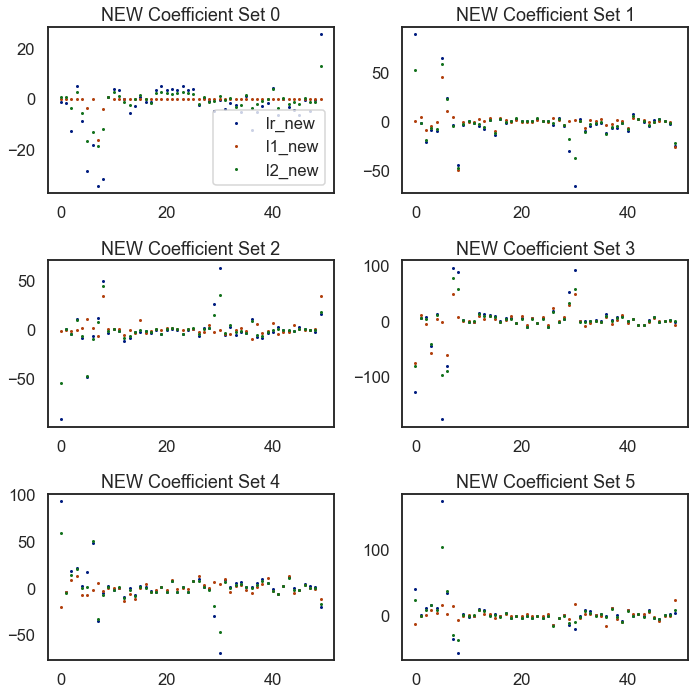

In [35]:
# try the plots with new values
# Utilizamos as funcoes fornecidas anteriormente para isso
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients_new.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='NEW Coefficient Set '+str(loc))

plt.tight_layout()

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [39]:
# Predict the class and the probability for each
# Utilizamos as funcoes fornecidas anteriormente para isso

y_pred_new = list()
y_prob_new = list()

coeff_labels_new = ['lr_new', 'l1_new', 'l2_new']
coeff_models_new = [lr_new, lr_l1_new, lr_l2_new]

for lab,mod in zip(coeff_labels_new, coeff_models_new):
    y_pred_new.append(pd.Series(mod.predict(X_test_new), name=lab))
    y_prob_new.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))
    
y_pred_new = pd.concat(y_pred_new, axis=1)
y_prob_new = pd.concat(y_prob_new, axis=1)

y_pred_new.head()

,lr_new,l1_new,l2_new
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [40]:
y_prob_new.head()

,lr_new,l1_new,l2_new
0,0.999999,0.997245,0.999998
1,0.999855,0.998116,0.999865
2,0.999998,0.984634,0.999995
3,0.878231,0.863715,0.880051
4,1.000000,0.999995,0.999999


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [43]:
# Calculate the error metrics as listed above
# Utilizamos as funcoes fornecidas anteriormente para isso

metrics_new = list()
cm_new = dict()

for lab in coeff_labels_new:

    # Preciision, recall, f-score from the multi-class support function
    precision_new, recall_new, fscore_new, _ = score(y_test_new, y_pred_new[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy_new = accuracy_score(y_test_new, y_pred_new[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc_new = roc_auc_score(label_binarize(y_test_new, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred_new[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm_new[lab] = confusion_matrix(y_test_new, y_pred_new[lab])
    
    metrics_new.append(pd.Series({'precision':precision_new, 'recall':recall_new, 
                              'fscore':fscore_new, 'accuracy':accuracy_new,
                              'auc':auc_new}, 
                             name=lab))

metrics_new = pd.concat(metrics_new, axis=1)

In [44]:
#Run the metrics
# Utilizamos as funcoes fornecidas anteriormente para isso
metrics_new

,lr_new,l1_new,l2_new
precision,0.937379,0.937318,0.937088
recall,0.937217,0.937217,0.936893
fscore,0.937221,0.937219,0.936900
accuracy,0.937217,0.937217,0.936893
auc,0.962353,0.962267,0.962177


## Question 13

Display or plot the confusion matrix for each model.

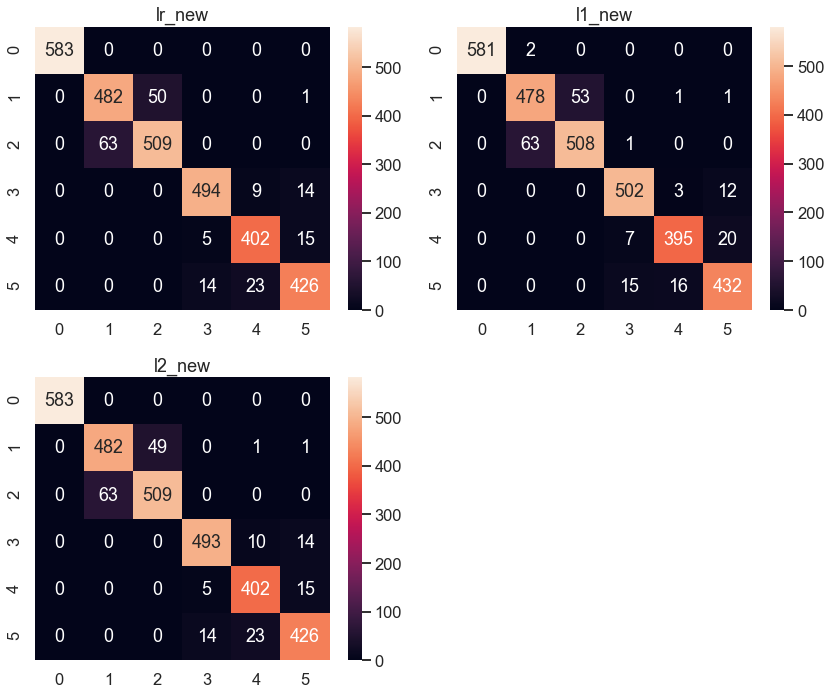

In [45]:
#plot the confusion matrix
# Utilizamos as funcoes fornecidas anteriormente para isso
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels_new):
    sns.heatmap(cm_new[lab], ax=ax, annot=True, fmt='d')
    ax.set(title=lab);
    
plt.tight_layout()

In [ ]:
'''arquivo = open('arquivo_lr.picle','rb')
data_lr = pickle.load(arquivo)
arquivo.close()
arquivo_l1 = open('arquivo_lr_l1.picle','rb')
data_lr_l1 = pickle.load(arquivo_l1)
arquivo_l1.close()
arquivo_l2 = open('arquivo_lr_l1.picle','rb')
data_lr_l2 = pickle.load(arquivo_l2)
arquivo_l2.close()'''

# Após carregar os resultados, executamos o exercicio 7 e 8 novamente para obter as metricas e a matriz de confusao anteriores

In [ ]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation

<span style="color:red">---------------------------------------------------------------------------------------------</span>
## <span style="color:red">RESPOSTA</span>

Da observação dos graficos, temos que aqueles gerados com o novo conjunto de dados apresentaram uma menor dispersão dos dados. Os valores foram organizados no eixo y entre -100 e 100 aproximadamente, enquanto para o conjunto de dados inicial foi de -500 e 500.

Com os resultados das métricas encontrados, unimos os resultados em uma tabela para facilitar a comparação. Esperávamos um resultado melhor que o primeiro, visto que realizamos uma seleção de features. No entanto obtivemos valores menores para todas as mátricas.		

|  -         | lr_new    |  l1_new   | l2_new    | lr       |	l1      |	l2     |
|------------|-----------|-----------|-----------| -------- | --------- | -------- |
| precision  | 0.937379  | 0.937318  | 0.937088  | 0.983785	| 0.983835	| 0.983837 |
| recall     | 0.937217  | 0.937217  | 0.936893  | 0.983819	| 0.983819	| 0.983819 |
| fscore     | 0.937221  | 0.937219  | 0.936900  | 0.983790	| 0.983815	| 0.983823 |
| accuracy   | 0.937217  | 0.937217  | 0.936893  | 0.983819	| 0.983819	| 0.983819 |
| auc        | 0.962353  | 0.962267  | 0.962177  | 0.990181	| 0.990144  | 0.990158 |

<span style="color:red">---------------------------------------------------------------------------------------------</span>

In [ ]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation

<span style="color:red">---------------------------------------------------------------------------------------------</span>
## <span style="color:red">RESPOSTA</span>



<span style="color:red">---------------------------------------------------------------------------------------------</span>